In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")


In [128]:

import matplotlib.pyplot as plt
import json
import math
import torch
import numpy
import pandas
import logging
import numpy as np
from tslearn.metrics import dtw



from IPython import embed
from common import scikit_wrappers, data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMD_dataset, load_CSV_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config


args = parse_arguments()

%matplotlib inline

In [2]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
def plot_window(window, x=None, dim=0, label="", color="b", legend=True):
    if not x:
        x = np.array(range(window.shape[1]))
    y = window[dim, :]
    plt.plot(x,y,color=color, label=label)
    if legend:
        plt.legend()

In [3]:
args["load"] = "./checkpoints/20201110-164903"

In [4]:
# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)

# load & preprocess data
pp = data_preprocess.preprocessor()
pp.load(params["save_path"])
params['in_channels'] = 1

logging.info("Proceeding using {}...".format(params["device"]))
logging.info(print_to_json(params))
# training
encoder = scikit_wrappers.CausalCNNEncoder(vocab_size=pp.vocab_size, **params)
if params["load"]:
    encoder.load_encoder()
else:
    encoder.fit(train_iterator, save_memory=False, verbose=True)
    encoder.save_encoder()

2020-11-10 19:28:55,458 P39406 INFO Loading preprocessor from ./checkpoints/20201110-164903/preprocessor.pkl
2020-11-10 19:28:55,460 P39406 INFO Proceeding using cpu...
2020-11-10 19:28:55,461 P39406 INFO {
    "batch_size": "64",
    "channels": "40",
    "compared_length": "None",
    "dataset": "machine-1-1",
    "depth": "2",
    "device": "cpu",
    "embedding_dim": "10",
    "expid": "casualCnn",
    "gpu": "0",
    "in_channels": "1",
    "kernel_size": "3",
    "load": "./checkpoints/20201110-164903",
    "lr": "0.001",
    "nb_random_samples": "5",
    "nb_steps": "2000",
    "negative_penalty": "1",
    "out_channels": "64",
    "path": "./datasets/Simulated/simulated_p1.csv",
    "penalty": "None",
    "reduced_size": "32",
    "save_path": "./checkpoints/20201110-164903",
    "trial_id": "20201110-164903",
    "window_size": "45"
}
2020-11-10 19:28:55,473 P39406 INFO Loading model from ./checkpoints/20201110-164903/CausalCNN_20201110-164903.pth


In [33]:
data_dict1 = load_CSV_dataset(params["path"], dataset="[3]: 1583_295")
data_dict2 = load_CSV_dataset(params["path"], dataset="[0]: 15449476_6265666") 
data_dict1_disc = pp.discretize(data_dict1, mode="test")
data_dict2_disc = pp.discretize(data_dict2, mode="test")

In [18]:
data_dict1.keys()

dict_keys(['dim', '[3]: 1583_295'])

In [164]:
train_windows1, test_windows1 = data_preprocess.generate_windows(data_dict1, window_size=params["window_size"])
train_windows2, test_windows2 = data_preprocess.generate_windows(data_dict2, window_size=params["window_size"])
train_windows1_disc, test_windows1_disc = data_preprocess.generate_windows(data_dict1_disc, window_size=params["window_size"])
train_windows2_disc, test_windows2_disc = data_preprocess.generate_windows(data_dict2_disc, window_size=params["window_size"])

In [56]:
train_windows1.shape

torch.Size([3000, 1, 1])

In [54]:
data_dict1["[3]: 1583_295"]["train"].shape

(12000, 1)

torch.Size([11956, 1, 45])

In [98]:
def find_topk_nearest(target, pool, k=5):
    return np.argsort(euclidean_distances(target, pool))[0:k]

array([[    0,  2408,  4003, ...,  1246, 11047,  8185]])

In [154]:
win = train_windows1[i].reshape(-1)
win[21] = 2800
win = win.reshape(1,-1)

In [155]:
win

tensor([[1297.7379, 1656.8651, 1611.8816, 1922.4554, 1209.5485, 1644.1110,
         1626.3591, 1223.9301, 1982.7705, 1377.2307, 1315.3308, 1731.1552,
         1355.5380, 1525.2906, 1997.4171, 1253.4006, 1819.0626, 1928.4811,
         1320.4028, 1765.6703, 1701.5294, 2800.0000, 1869.3859, 1433.5192,
         1643.3289, 1705.6924, 1487.3538, 1515.6062, 1949.7056, 1273.0355,
         1959.7191, 1243.0853, 1895.4670, 1530.3247, 1766.0411, 1367.7433,
         1504.1002, 1144.2533, 1832.1921, 1894.0042, 1598.2788, 1960.5049,
         2008.2614, 1463.6309, 1368.9801]])

[[0.886609]]
[[0.90542865]]


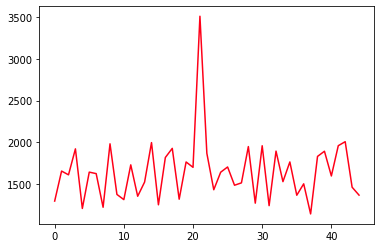

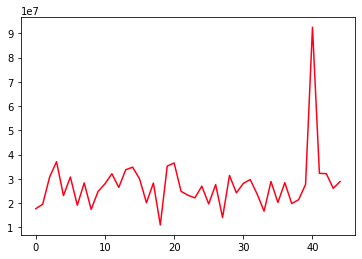

In [178]:
i = 4980
cmap = get_cmap(10)
window_size=params["window_size"]
# slice = range(window_size*i,window_size*(i+1))
plot_window(train_windows1[4980], x=slice, color=cmap(i), legend=False)
plt.figure()

plot_window(train_windows2[4960], x=slice, color=cmap(i), legend=False)

print(cosine_similarity(train_windows1_disc[4980], train_windows2_disc[4960]))
print(cosine_similarity(train_windows1[4980], train_windows2[4960]))

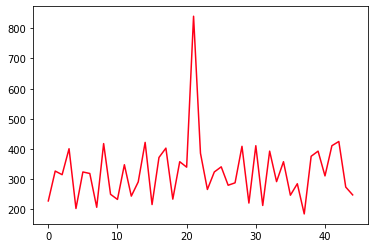

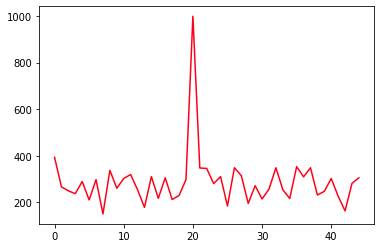

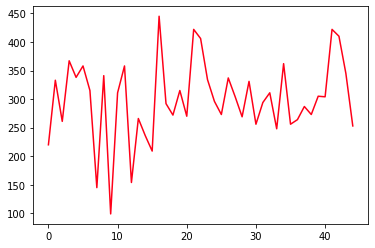

In [162]:
i = 4980
cmap = get_cmap(10)
window_size=params["window_size"]
# slice = range(window_size*i,window_size*(i+1))
plot_window(train_windows1_disc[4980], x=slice, color=cmap(i), legend=False)
plt.figure()

plot_window(train_windows2_disc[4980], x=slice, color=cmap(i), legend=False)
plt.figure()
plot_window(train_windows1_disc[3627], x=slice, color=cmap(i), legend=False)

[[0.8842065]]


[[0.9021852]]


In [167]:
train_windows1_disc[4981]

tensor([[327., 315., 401., 203., 324., 319., 207., 418., 250., 233., 348., 244.,
         291., 422., 216., 372., 403., 234., 358., 340., 840., 386., 266., 324.,
         341., 280., 288., 409., 221., 411., 213., 393., 292., 358., 247., 285.,
         185., 376., 393., 311., 411., 425., 274., 248., 234.]])

In [168]:
train_windows2_disc[4981]

tensor([[267., 250., 238., 290., 211., 298., 151., 338., 261., 303., 320., 255.,
         179., 311., 218., 306., 213., 230., 298., 999., 348., 346., 281., 311.,
         185., 349., 315., 196., 272., 215., 257., 349., 255., 217., 354., 310.,
         349., 232., 248., 303., 227., 164., 282., 306., 301.]])

In [105]:
euclidean_distances(train_windows1[i], train_windows1[4981])

array([[3722.502]], dtype=float32)

In [83]:
print(train_windows1_disc[i], train_windows2_disc[i], train_windows2_disc[i-100])

tensor([[228., 327., 315., 401., 203., 324., 319., 207., 418., 250., 233., 348.,
         244., 291., 422., 216., 372., 403., 234., 358., 340., 840., 386., 266.,
         324., 341., 280., 288., 409., 221., 411., 213., 393., 292., 358., 247.,
         285., 185., 376., 393., 311., 411., 425., 274., 248.]]) tensor([[394., 267., 250., 238., 290., 211., 298., 151., 338., 261., 303., 320.,
         255., 179., 311., 218., 306., 213., 230., 298., 999., 348., 346., 281.,
         311., 185., 349., 315., 196., 272., 215., 257., 349., 255., 217., 354.,
         310., 349., 232., 248., 303., 227., 164., 282., 306.]]) tensor([[327., 227., 165., 293., 346., 215., 238., 248., 239., 352., 296., 321.,
         302., 274., 422., 240., 257., 384., 293., 286., 291., 282., 173., 236.,
         321., 234., 372., 256., 283., 249., 147., 246., 333., 380., 262., 301.,
         348., 250., 368., 315., 385., 266., 188., 174., 311.]])


In [134]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
emb1 = encoder.encode(train_windows1_disc[4980].reshape(1,1,1,-1)).numpy().reshape(-1)
emb2 = encoder.encode(train_windows2_disc[4980].reshape(1,1,1,-1)).numpy().reshape(-1)
emb3 = encoder.encode(train_windows1_disc[3627].reshape(1,1,1,-1)).numpy().reshape(-1)

print("embeding")
print(cosine_similarity(emb1.reshape(1,-1), np.array([emb2, emb3])))
print(euclidean_distances(emb1.reshape(1,-1), np.array([emb2,emb3])))

print("离散化前raw")
print(cosine_similarity(train_windows1[i], train_windows2[4981]))
print(cosine_similarity(train_windows1[i], train_windows1[3627]))

print("离散化后raw")
print(cosine_similarity(train_windows1_disc[4981], train_windows2_disc[4981]))
print(cosine_similarity(train_windows1_disc[i], train_windows1_disc[3627]))

print("离散化后raw + dtw")
print(dtw(train_windows1_disc[i], train_windows2_disc[4981]))
print(dtw(train_windows1_disc[i], train_windows1_disc[3627]))
# print(euclidean_distances(emb1, emb3))

embeding
[[-0.03615333  0.62971793]]
[[3.99260369 1.78716348]]
离散化前raw
[[0.9045925]]
[[0.9793707]]
离散化后raw
[[0.88528764]]
[[0.96052206]]
离散化后raw + dtw
1067.2675390922373
652.612442418929


In [121]:
np.array([emb2,emb3]).shape

(2, 64)

In [11]:
sample_window = test_windows[0:100]
test_iterator = WindowIterator(sample_window, batch_size=1000, shuffle=False)

In [12]:
# inference
features = encoder.encode(test_iterator.loader)
logging.info("Final features have shape: {}".format(features.shape))

2020-11-10 16:51:42,764 P20162 INFO Final features have shape: torch.Size([100, 64])


In [13]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=502)
X_tsne = tsne.fit_transform(features)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化

0.72


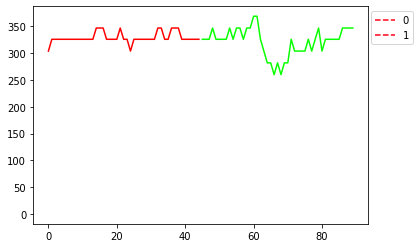

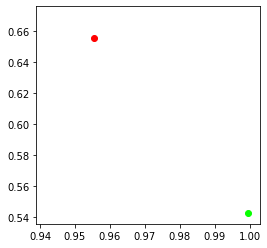

In [50]:
window_size = 45
n_window = 2
start_window=100
cmap = get_cmap(2*n_window)
raw_windows = []
ploted_windows = []
for i in range(n_window):
    w = test_windows[start_window + i*window_size, :, :]
    plot_window(w, x=range(window_size*i,window_size*(i+1)), color=cmap(i), legend=False)
    plt.vlines(window_size*i, 0.1, 0.5, label=i, colors = cmap(i+5), linestyles = "dashed")
    raw_windows.append(w) 
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

    
plt.figure(figsize=(4, 4))
for i in range(n_window):
    w_idx = start_window+i*window_size
    reprentation = features[w_idx]
    plt.scatter(X_norm[w_idx, 0], X_norm[w_idx, 1], color=cmap(i))
    ploted_windows.append(reprentation)
    

for i in range(len(ploted_windows)-1):
#     dist = np.sqrt(sum((ploted_windows[i].reshape(-1) - ploted_windows[i+1].reshape(-1))**2))
    dist = cosine_similarity(ploted_windows[i].reshape(1,-1), ploted_windows[i+1].reshape(1,-1))
#     dist = np.dot(ploted_windows[i], ploted_windows[i+1])
#     print(i, i+1, dist[0][0])
    print(round(dist[0][0],3))

In [46]:
raw_windows

[tensor([[173., 173., 173., 173., 173., 173., 173., 173., 173., 173., 173., 152.,
          173., 173., 173., 173., 173., 173., 173., 173., 173., 173., 173., 173.,
          173., 173., 173., 173., 173., 173., 173., 152., 173., 173., 173., 195.,
          173., 195., 195., 195., 195., 173., 173., 173., 195.]]),
 tensor([[195., 195., 195., 195., 195., 195., 195., 195., 173., 195., 195., 173.,
          173., 195., 195., 195., 195., 173., 195., 195., 195., 195., 217., 195.,
          304., 282., 239., 260., 260., 282., 260., 282., 304., 282., 304., 304.,
          304., 304., 304., 304., 304., 304., 304., 304., 326.]])]